In [1]:
# In this notebook, I explore a small data set and engineer some new features using natural language processing. The
# goal is to find predictors for likelihood of a book being a bestseller, where having a star rating of at least 4.5
# and at least 100 reviews is the criterion for being a likely bestseller.

# This was one of my first NLP projects.

In [76]:
import nltk
import pandas as pd
import numpy as np
from textblob import TextBlob
from gensim import corpora, models, matutils

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')



In [3]:
df = pd.read_excel('2016_YA_books.xlsx', encoding='utf-8')

df.head()

,Book title,Author name,Star rating,Number of reviews,Length,Publisher
0,Mistrust,Margaret McHeyzer,4.5,64,333,Amazon
1,Girl in Pieces,Kathleen Glasgow,4.5,139,418,Delacorte
2,Just Juliet,Charlotte Reagan,4.5,369,224,Inkitt
3,Dork in Love ~ Tales of My Dorky Love Life: Te...,Ann Writes,4.5,9,122,Amazon
4,Warrior Cats: Battle (Warrior Cats (Werecat YA...,Tiyana Angel,5.0,1,52,Guardian Angel Press


In [4]:
df.shape

(100, 6)

In [5]:
df['Publisher'].value_counts()

Amazon                                    16
Delacorte                                  7
HarperCollins Publishers                   7
Skyscrape                                  5
BLVNP Incorporated                         4
Simon Pulse                                3
Harlequin Teen                             3
Disney Hyperion                            2
Dreamscape Publishing                      2
Bloomsbury USA Childrens                   2
Knopf Books for Young Readers              2
Philomel Books                             2
Atheneum/Caitlyn Dlouhy Books              2
Blaze Publishing                           1
Simon and Schuster                         1
Inkitt                                     1
Soho Teen                                  1
Random House Books for Young Readers       1
HMH Books for Young Readers                1
Hollis Thatcher Press                      1
Swoon Reads                                1
Harlequin Kimana TRU                       1
Viking Boo

In [6]:
df['Publisher'].sort_values().unique()

array([u'Amazon ', u'Amulet Books', u'Amy Sparling Books',
       u'Another World Press', u'Atheneum/Caitlyn Dlouhy Books',
       u'BLVNP Incorporated', u'Blaze Publishing', u'Bloomsbury Spark',
       u'Bloomsbury USA Childrens', u'Blue Tulip Publishing',
       u'Candlewick', u'Crown Books for Young Readers',
       u'Darwin House Press', u'DashingBooks', u'Delacorte',
       u'Disney Hyperion', u'Disney Lucasfilm Press', u'Disney Press',
       u'Dreamscape Publishing', u'Entangled: Crush', u'Entangled: Teen',
       u'Flatiron Books', u'Greenwillow Books', u'Guardian Angel Press',
       u'HMH Books for Young Readers', u'Harlequin Kimana TRU',
       u'Harlequin Teen', u'HarperCollins Publishers', u'HarperTeen',
       u'Hatco Publishing', u'Hollis Thatcher Press', u'Inkitt',
       u'Katherine Tegen Books', u'Knopf Books for Young Readers',
       u'Lighthouse Publishing of the Carolinas', u'Mind Mess Press',
       u'Month9Books', u'Philomel Books', u'Plebian Media', u'Pottermor

In [44]:
len(df['Publisher'].unique())

56

In [7]:
df['Publisher'].value_counts()

Amazon                                    16
Delacorte                                  7
HarperCollins Publishers                   7
Skyscrape                                  5
BLVNP Incorporated                         4
Simon Pulse                                3
Harlequin Teen                             3
Disney Hyperion                            2
Dreamscape Publishing                      2
Bloomsbury USA Childrens                   2
Knopf Books for Young Readers              2
Philomel Books                             2
Atheneum/Caitlyn Dlouhy Books              2
Blaze Publishing                           1
Simon and Schuster                         1
Inkitt                                     1
Soho Teen                                  1
Random House Books for Young Readers       1
HMH Books for Young Readers                1
Hollis Thatcher Press                      1
Swoon Reads                                1
Harlequin Kimana TRU                       1
Viking Boo

In [8]:
df.isnull().sum()

Book title           0
Author name          0
Star rating          0
Number of reviews    0
Length               0
Publisher            0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
Book title           100 non-null object
Author name          100 non-null object
Star rating          100 non-null float64
Number of reviews    100 non-null int64
Length               100 non-null int64
Publisher            100 non-null object
dtypes: float64(1), int64(2), object(3)
memory usage: 4.8+ KB


In [10]:
df['likely_bestseller'] = ((df['Star rating'] >= 4.5) & (df['Number of reviews'] >=100)).astype(int)

In [11]:
df.head()

,Book title,Author name,Star rating,Number of reviews,Length,Publisher,likely_bestseller
0,Mistrust,Margaret McHeyzer,4.5,64,333,Amazon,0
1,Girl in Pieces,Kathleen Glasgow,4.5,139,418,Delacorte,1
2,Just Juliet,Charlotte Reagan,4.5,369,224,Inkitt,1
3,Dork in Love ~ Tales of My Dorky Love Life: Te...,Ann Writes,4.5,9,122,Amazon,0
4,Warrior Cats: Battle (Warrior Cats (Werecat YA...,Tiyana Angel,5.0,1,52,Guardian Angel Press,0


In [12]:
df['likely_bestseller'].value_counts()

0    73
1    27
Name: likely_bestseller, dtype: int64

In [13]:
from textacy.preprocess import preprocess_text

In [14]:
df['title_clean'] = [preprocess_text(x, fix_unicode=True, lowercase=True, transliterate=False,
                              no_urls=True, no_emails=True, no_phone_numbers=True, no_currency_symbols=True,
                              no_punct=True, no_accents=True)
              for x in df['Book title']]

df

,Book title,Author name,Star rating,Number of reviews,Length,Publisher,likely_bestseller,title_clean
0,Mistrust,Margaret McHeyzer,4.5,64,333,Amazon,0,mistrust
1,Girl in Pieces,Kathleen Glasgow,4.5,139,418,Delacorte,1,girl in pieces
2,Just Juliet,Charlotte Reagan,4.5,369,224,Inkitt,1,just juliet
3,Dork in Love ~ Tales of My Dorky Love Life: Te...,Ann Writes,4.5,9,122,Amazon,0,dork in love tales of my dorky love life teen ...
4,Warrior Cats: Battle (Warrior Cats (Werecat YA...,Tiyana Angel,5.0,1,52,Guardian Angel Press,0,warrior cats battle warrior cats werecat ya pa...
5,Out of Beat (Boys of Fallout Book 1),Cassandra Giovanni,4.5,11,231,Show not Tell Publishing,0,out of beat boys of fallout book 1
6,A Different Truth,Annette Oppenlander,4.5,25,256,Amazon,0,a different truth
7,Tell Me Three Things,Julie Buxbaum,4.5,218,338,Delacorte,1,tell me three things
8,The Fever Code: Book Five,James Dashner,4.5,235,384,Delacorte,1,the fever code book five
9,The Passion of Dolssa,Julie Berry,4.5,57,496,Viking Books for Young Readers,0,the passion of dolssa


In [15]:
all_titles_text = ' '.join(df['title_clean'])

In [16]:
all_titles_text

u'mistrust girl in pieces just juliet dork in love tales of my dorky love life teen romance warrior cats battle warrior cats werecat ya paranormal book 4 out of beat boys of fallout book 1 a different truth tell me three things the fever code book five the passion of dolssa saven deception scifi alien romance the saven series book 1 his to claim hunger is the best sauce paper princess a novel the royals book 1 mated to the alpha king king of beasts if i fix you if wishes were horses a bittersweet farm novella the sun is also a star salt to the sea as old as time a twisted tale wake city of light book 1 suddenly the best possible answer a novel the crush dilemma dear aubrey book 1 infinity rises the infinity trilogy book 2 infinity reborn the infinity trilogy book 3 broken prince a novel the royals book 2 age of order cling a post apocalyptic thriller faerie rift the tales of beedle the bard hogwarts library book on the meldon plain the fourline trilogy book 2 star wars ahsoka calamity 

In [17]:
df['Author name'].value_counts()

Erin Watt                           2
Michelle Madow                      2
S. Harrison                         2
Amy Sparling                        2
Sarah J. Maas                       1
Leah Konen                          1
James Frey                          1
Jennifer Niven                      1
Sherry Rossman                      1
Addison Moore                       1
Kiera Cass                          1
Megan Crewe                         1
Jen Klein                           1
R.K. Ryals                          1
Chelsea M. Campbell                 1
Brittney Mulliner                   1
Sandy Hall                          1
Nicole Castroman                    1
Lauren Oliver                       1
Nicole Conway                       1
Mimi Cross                          1
Kohei Horikoshi                     1
Z.A. Coe                            1
Kerry Kletter                       1
Jenna Evans Welch                   1
Corinne Duyvis                      1
Eileen Cook 

In [18]:
df['title_length'] = [len(s.split()) for s in df['title_clean']]

In [19]:
df.head()

,Book title,Author name,Star rating,Number of reviews,Length,Publisher,likely_bestseller,title_clean,title_length
0,Mistrust,Margaret McHeyzer,4.5,64,333,Amazon,0,mistrust,1
1,Girl in Pieces,Kathleen Glasgow,4.5,139,418,Delacorte,1,girl in pieces,3
2,Just Juliet,Charlotte Reagan,4.5,369,224,Inkitt,1,just juliet,2
3,Dork in Love ~ Tales of My Dorky Love Life: Te...,Ann Writes,4.5,9,122,Amazon,0,dork in love tales of my dorky love life teen ...,11
4,Warrior Cats: Battle (Warrior Cats (Werecat YA...,Tiyana Angel,5.0,1,52,Guardian Angel Press,0,warrior cats battle warrior cats werecat ya pa...,10


In [20]:
import spacy

In [21]:
english_parser = spacy.load('en')

In [22]:
parsed_quotes = []
for i, parsed in enumerate(english_parser.pipe(df['title_clean'].values, batch_size=50, n_threads=4)):
    assert parsed.is_parsed
    if (i % 1000) == 0:
        print i
    parsed_quotes.append(parsed)   
parsed_quotes[0]

0


mistrust

In [23]:
unique_pos = []
for parsed in parsed_quotes:
    unique_pos.extend([each_word.pos_ for each_word in parsed])
unique_pos = np.unique(unique_pos)
print unique_pos

[u'ADJ' u'ADP' u'ADV' u'CONJ' u'DET' u'NOUN' u'NUM' u'PART' u'PRON'
 u'PUNCT' u'VERB']


In [24]:
len(unique_pos)

11

In [25]:
##### Initialize the Columns with all Zeros ########
for pos in unique_pos:
    df[pos+'_prop'] = 0.
df.head(3)

,Book title,Author name,Star rating,Number of reviews,Length,Publisher,likely_bestseller,title_clean,title_length,ADJ_prop,ADP_prop,ADV_prop,CONJ_prop,DET_prop,NOUN_prop,NUM_prop,PART_prop,PRON_prop,PUNCT_prop,VERB_prop
0,Mistrust,Margaret McHeyzer,4.5,64,333,Amazon,0,mistrust,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Girl in Pieces,Kathleen Glasgow,4.5,139,418,Delacorte,1,girl in pieces,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Just Juliet,Charlotte Reagan,4.5,369,224,Inkitt,1,just juliet,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
######## Now populate the columns with Proportions for each Row ####
for i, parsed in enumerate(parsed_quotes):
    if (i % 1000) == 0:
        print i
    parsed_len = len(parsed)
    for pos in unique_pos:
        count = len([each_word for each_word in parsed if each_word.pos_ == pos])
        df.ix[i, pos+'_prop'] = float(count)/parsed_len
    
df

0


,Book title,Author name,Star rating,Number of reviews,Length,Publisher,likely_bestseller,title_clean,title_length,ADJ_prop,ADP_prop,ADV_prop,CONJ_prop,DET_prop,NOUN_prop,NUM_prop,PART_prop,PRON_prop,PUNCT_prop,VERB_prop
0,Mistrust,Margaret McHeyzer,4.5,64,333,Amazon,0,mistrust,1,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00,0.0,0.000000
1,Girl in Pieces,Kathleen Glasgow,4.5,139,418,Delacorte,1,girl in pieces,3,0.000000,0.333333,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,0.00,0.0,0.000000
2,Just Juliet,Charlotte Reagan,4.5,369,224,Inkitt,1,just juliet,2,0.000000,0.000000,0.500000,0.000000,0.000000,0.500000,0.000000,0.000000,0.00,0.0,0.000000
3,Dork in Love ~ Tales of My Dorky Love Life: Te...,Ann Writes,4.5,9,122,Amazon,0,dork in love tales of my dorky love life teen ...,11,0.181818,0.181818,0.000000,0.000000,0.000000,0.636364,0.000000,0.000000,0.00,0.0,0.000000
4,Warrior Cats: Battle (Warrior Cats (Werecat YA...,Tiyana Angel,5.0,1,52,Guardian Angel Press,0,warrior cats battle warrior cats werecat ya pa...,10,0.300000,0.000000,0.000000,0.000000,0.000000,0.300000,0.100000,0.000000,0.10,0.0,0.200000
5,Out of Beat (Boys of Fallout Book 1),Cassandra Giovanni,4.5,11,231,Show not Tell Publishing,0,out of beat boys of fallout book 1,8,0.000000,0.375000,0.000000,0.000000,0.000000,0.375000,0.125000,0.000000,0.00,0.0,0.125000
6,A Different Truth,Annette Oppenlander,4.5,25,256,Amazon,0,a different truth,3,0.333333,0.000000,0.000000,0.000000,0.333333,0.333333,0.000000,0.000000,0.00,0.0,0.000000
7,Tell Me Three Things,Julie Buxbaum,4.5,218,338,Delacorte,1,tell me three things,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.250000,0.000000,0.25,0.0,0.250000
8,The Fever Code: Book Five,James Dashner,4.5,235,384,Delacorte,1,the fever code book five,5,0.000000,0.000000,0.000000,0.000000,0.200000,0.600000,0.200000,0.000000,0.00,0.0,0.000000
9,The Passion of Dolssa,Julie Berry,4.5,57,496,Viking Books for Young Readers,0,the passion of dolssa,4,0.000000,0.250000,0.000000,0.000000,0.250000,0.500000,0.000000,0.000000,0.00,0.0,0.000000


In [27]:
pd.get_dummies('Publisher')

,Publisher
0,1


In [75]:
df.describe()

,star_rating,num_reviews,length,likely_bestseller,title_length,ADJ_prop,ADP_prop,ADV_prop,CONJ_prop,DET_prop,NOUN_prop,NUM_prop,PART_prop,PRON_prop,PUNCT_prop,VERB_prop
count,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,4.315000,164.55000,327.440000,0.270000,4.300000,0.109362,0.073644,0.032679,0.006762,0.139790,0.458264,0.032603,0.005833,0.026667,0.001667,0.112730
std,0.399842,261.62601,116.095861,0.446196,2.337658,0.171288,0.121919,0.135517,0.041065,0.146270,0.248431,0.070653,0.041464,0.093534,0.016667,0.157553
min,3.000000,1.00000,52.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,28.00000,242.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.500000,74.50000,323.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.500000,179.00000,400.000000,1.000000,6.000000,0.200000,0.142857,0.000000,0.000000,0.250000,0.600000,0.000000,0.000000,0.000000,0.000000,0.200000
max,5.000000,1591.00000,793.000000,1.000000,11.000000,1.000000,0.500000,1.000000,0.333333,0.500000,1.000000,0.333333,0.333333,0.500000,0.166667,0.666667


In [28]:
df_corr = df.corr()

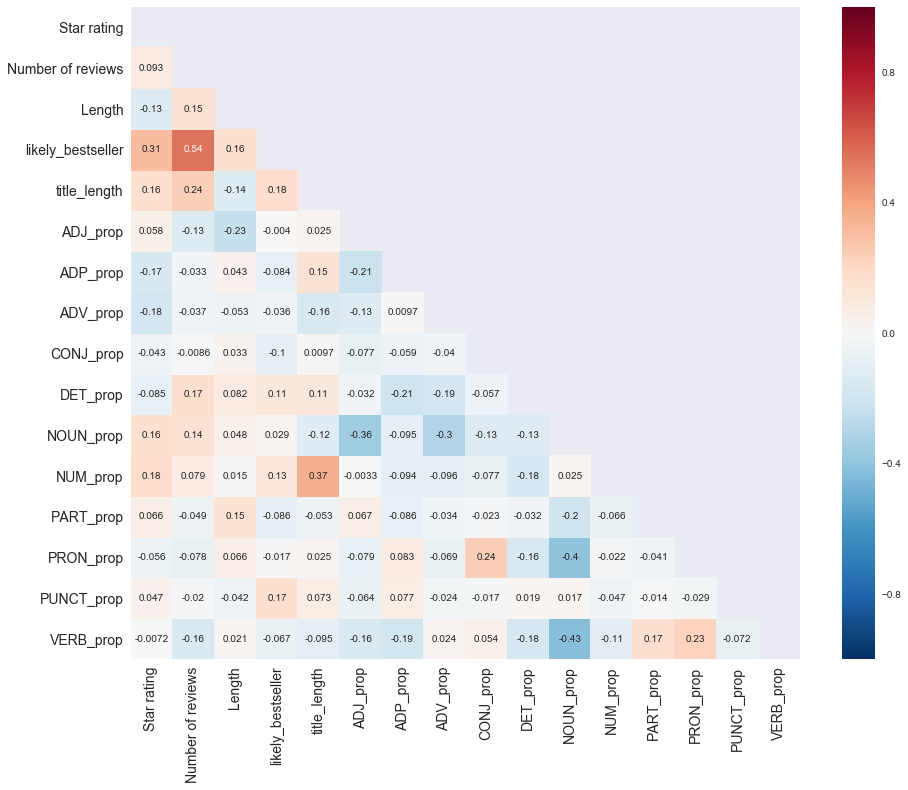

In [29]:
df_corr = df.corr()

fix, ax = plt.subplots(figsize=(15,12))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(df_corr, mask=mask, ax=ax, annot=True)
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

plt.show()

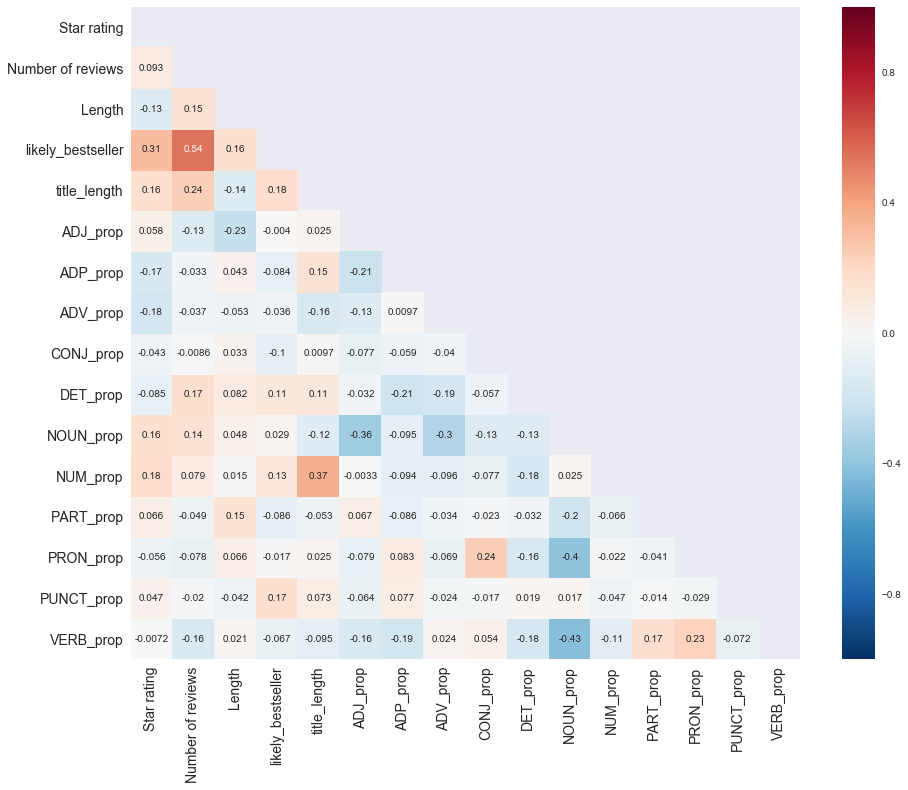

In [30]:
# heatmap with the diagonal and upper-right portion masked; annot=True to display correlation values

# Set the default matplotlib figure size to 11x9:
fix, ax = plt.subplots(figsize=(15,12))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(df_corr, mask=mask, ax=ax, annot=True)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

/Applications/anaconda/lib/python2.7/site-packages/statsmodels/nonparametric/kernels.py:127: RuntimeWarning: divide by zero encountered in divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/Applications/anaconda/lib/python2.7/site-packages/statsmodels/nonparametric/kernels.py:127: RuntimeWarning: invalid value encountered in divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/Applications/anaconda/lib/python2.7/site-packages/statsmodels/nonparametric/_kernel_base.py:514: RuntimeWarning: invalid value encountered in divide
  dens = Kval.prod(axis=1) / np.prod(bw[iscontinuous])
/Applications/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


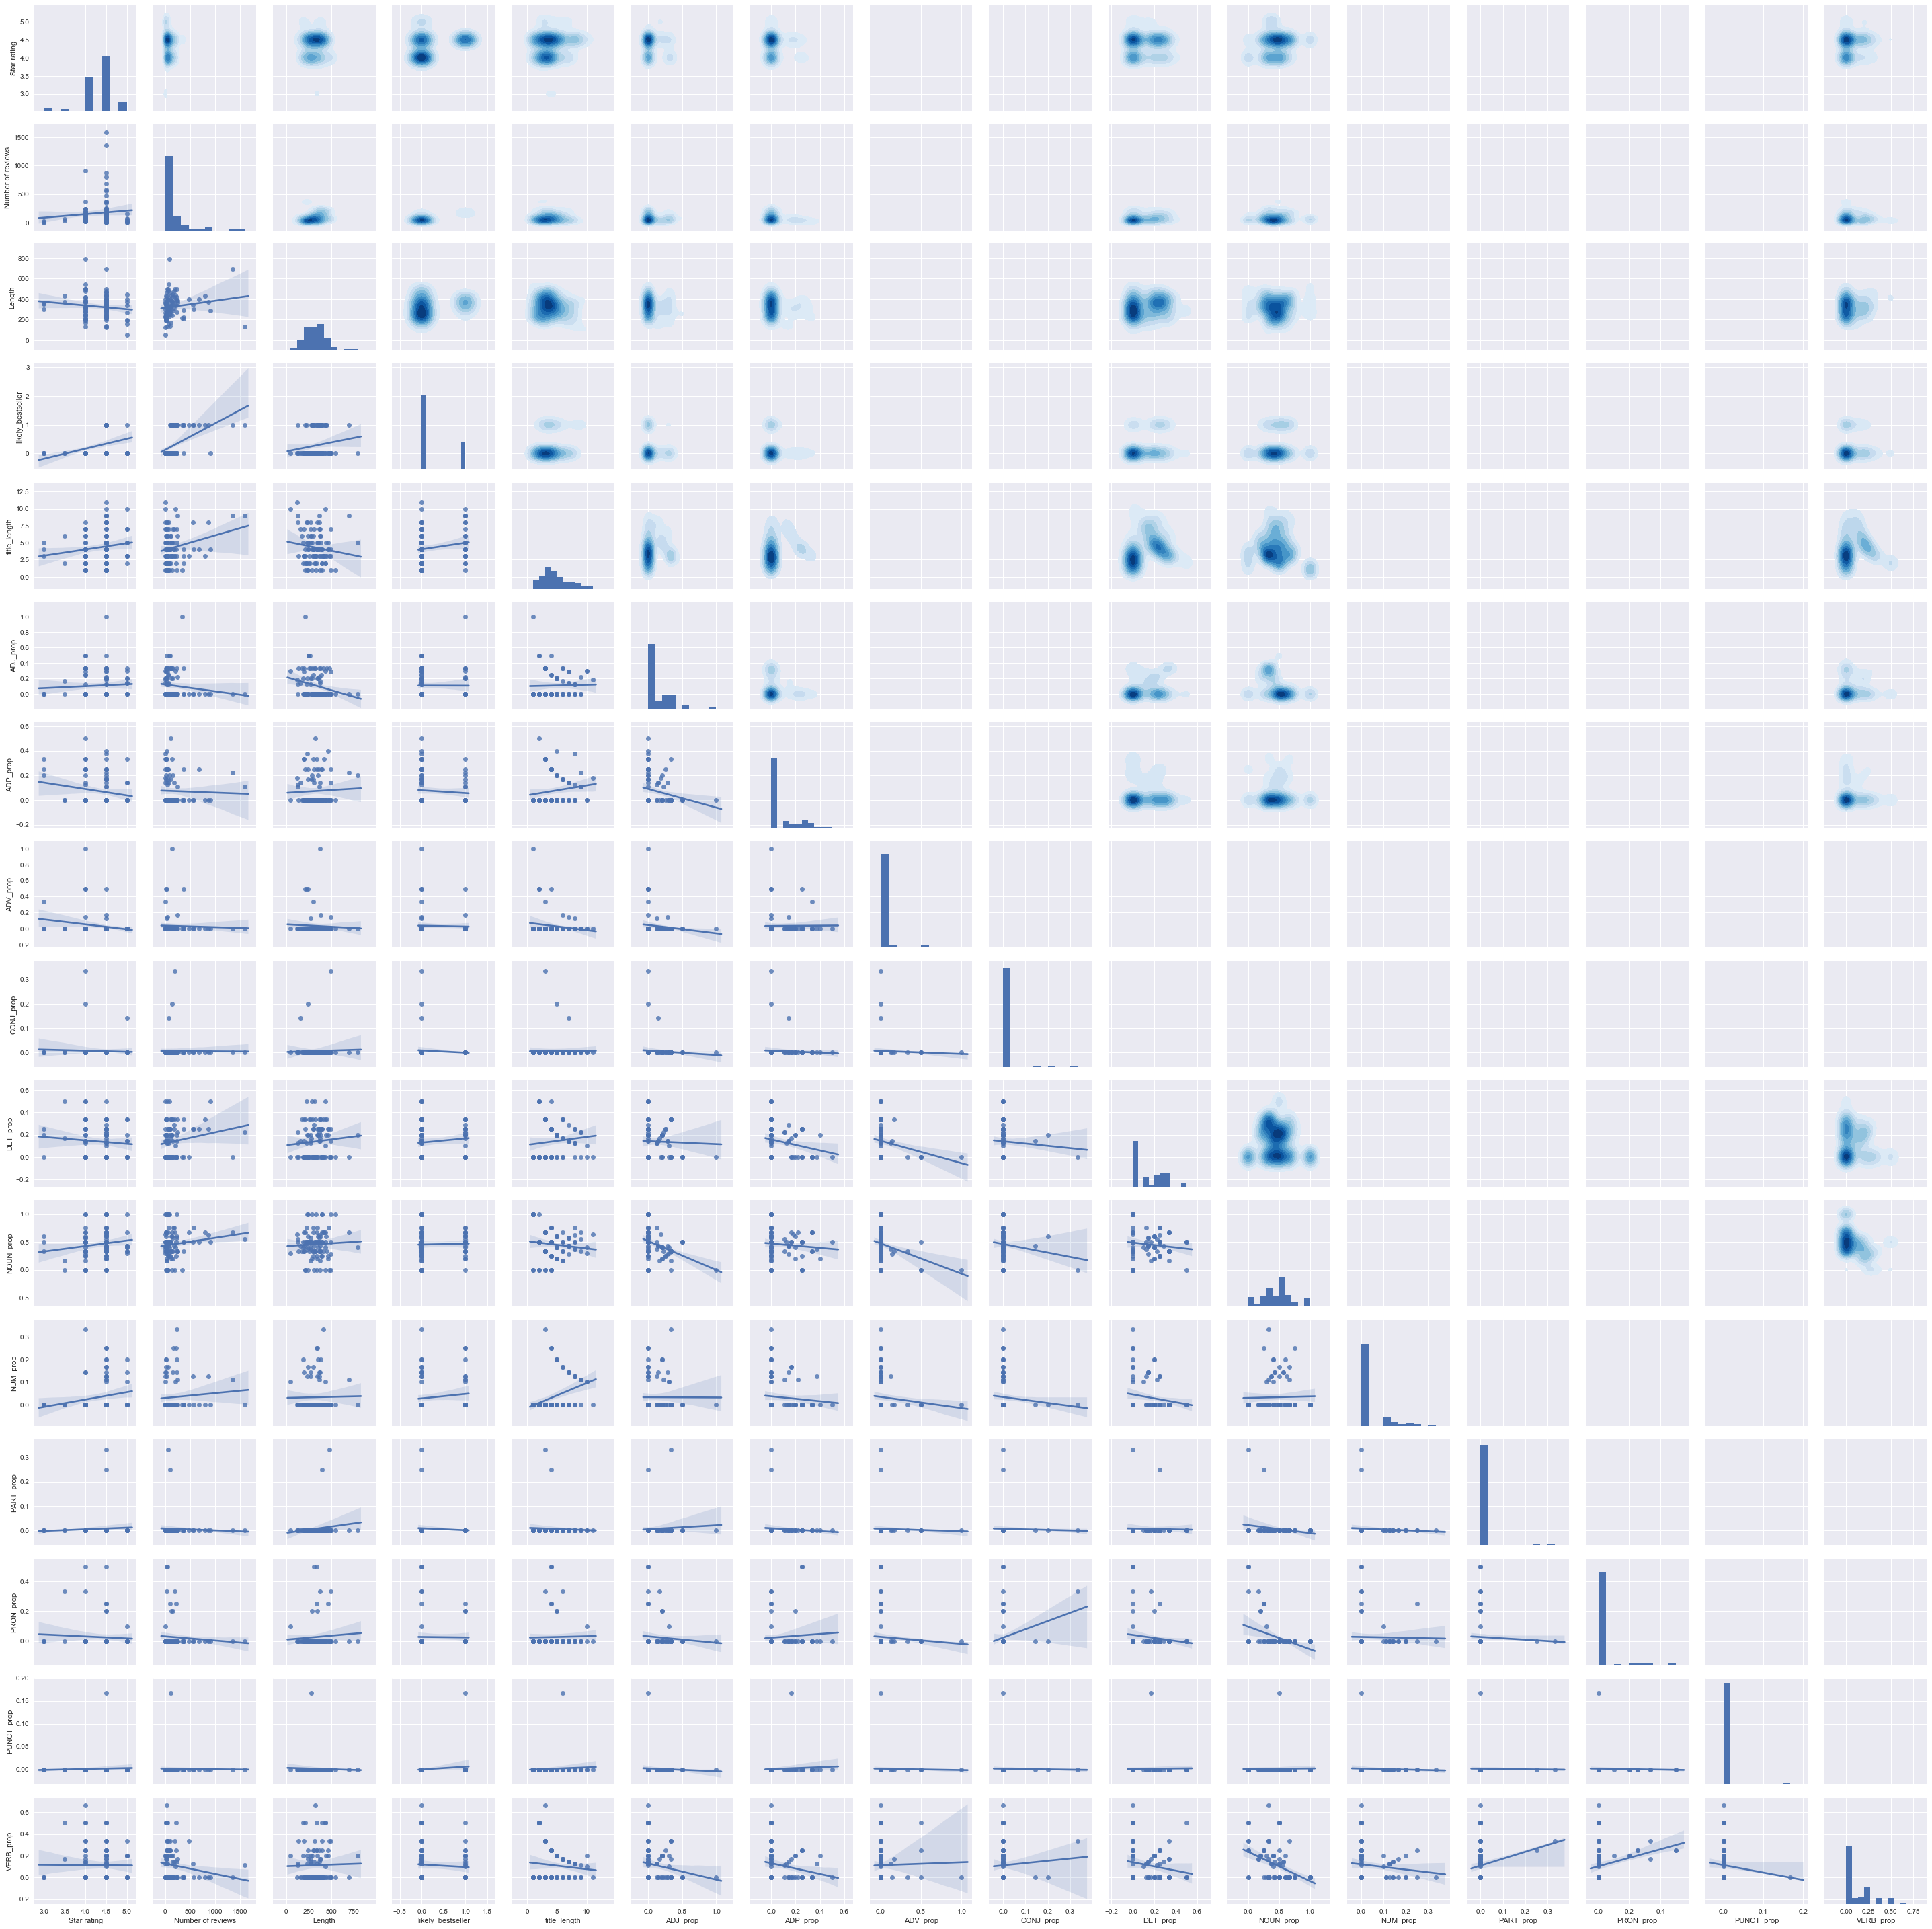

In [31]:
# better use of full PairGrid than a pure pairplot:

g = sns.PairGrid(df)
g = g.map_lower(sns.regplot)    # regression plots in lower tri
g = g.map_upper(sns.kdeplot, cmap="Blues", shade=True, shade_lowest=False)  # KDE plots in upper tri
g = g.map_diag(plt.hist)        # histograms along diagonal

plt.show()

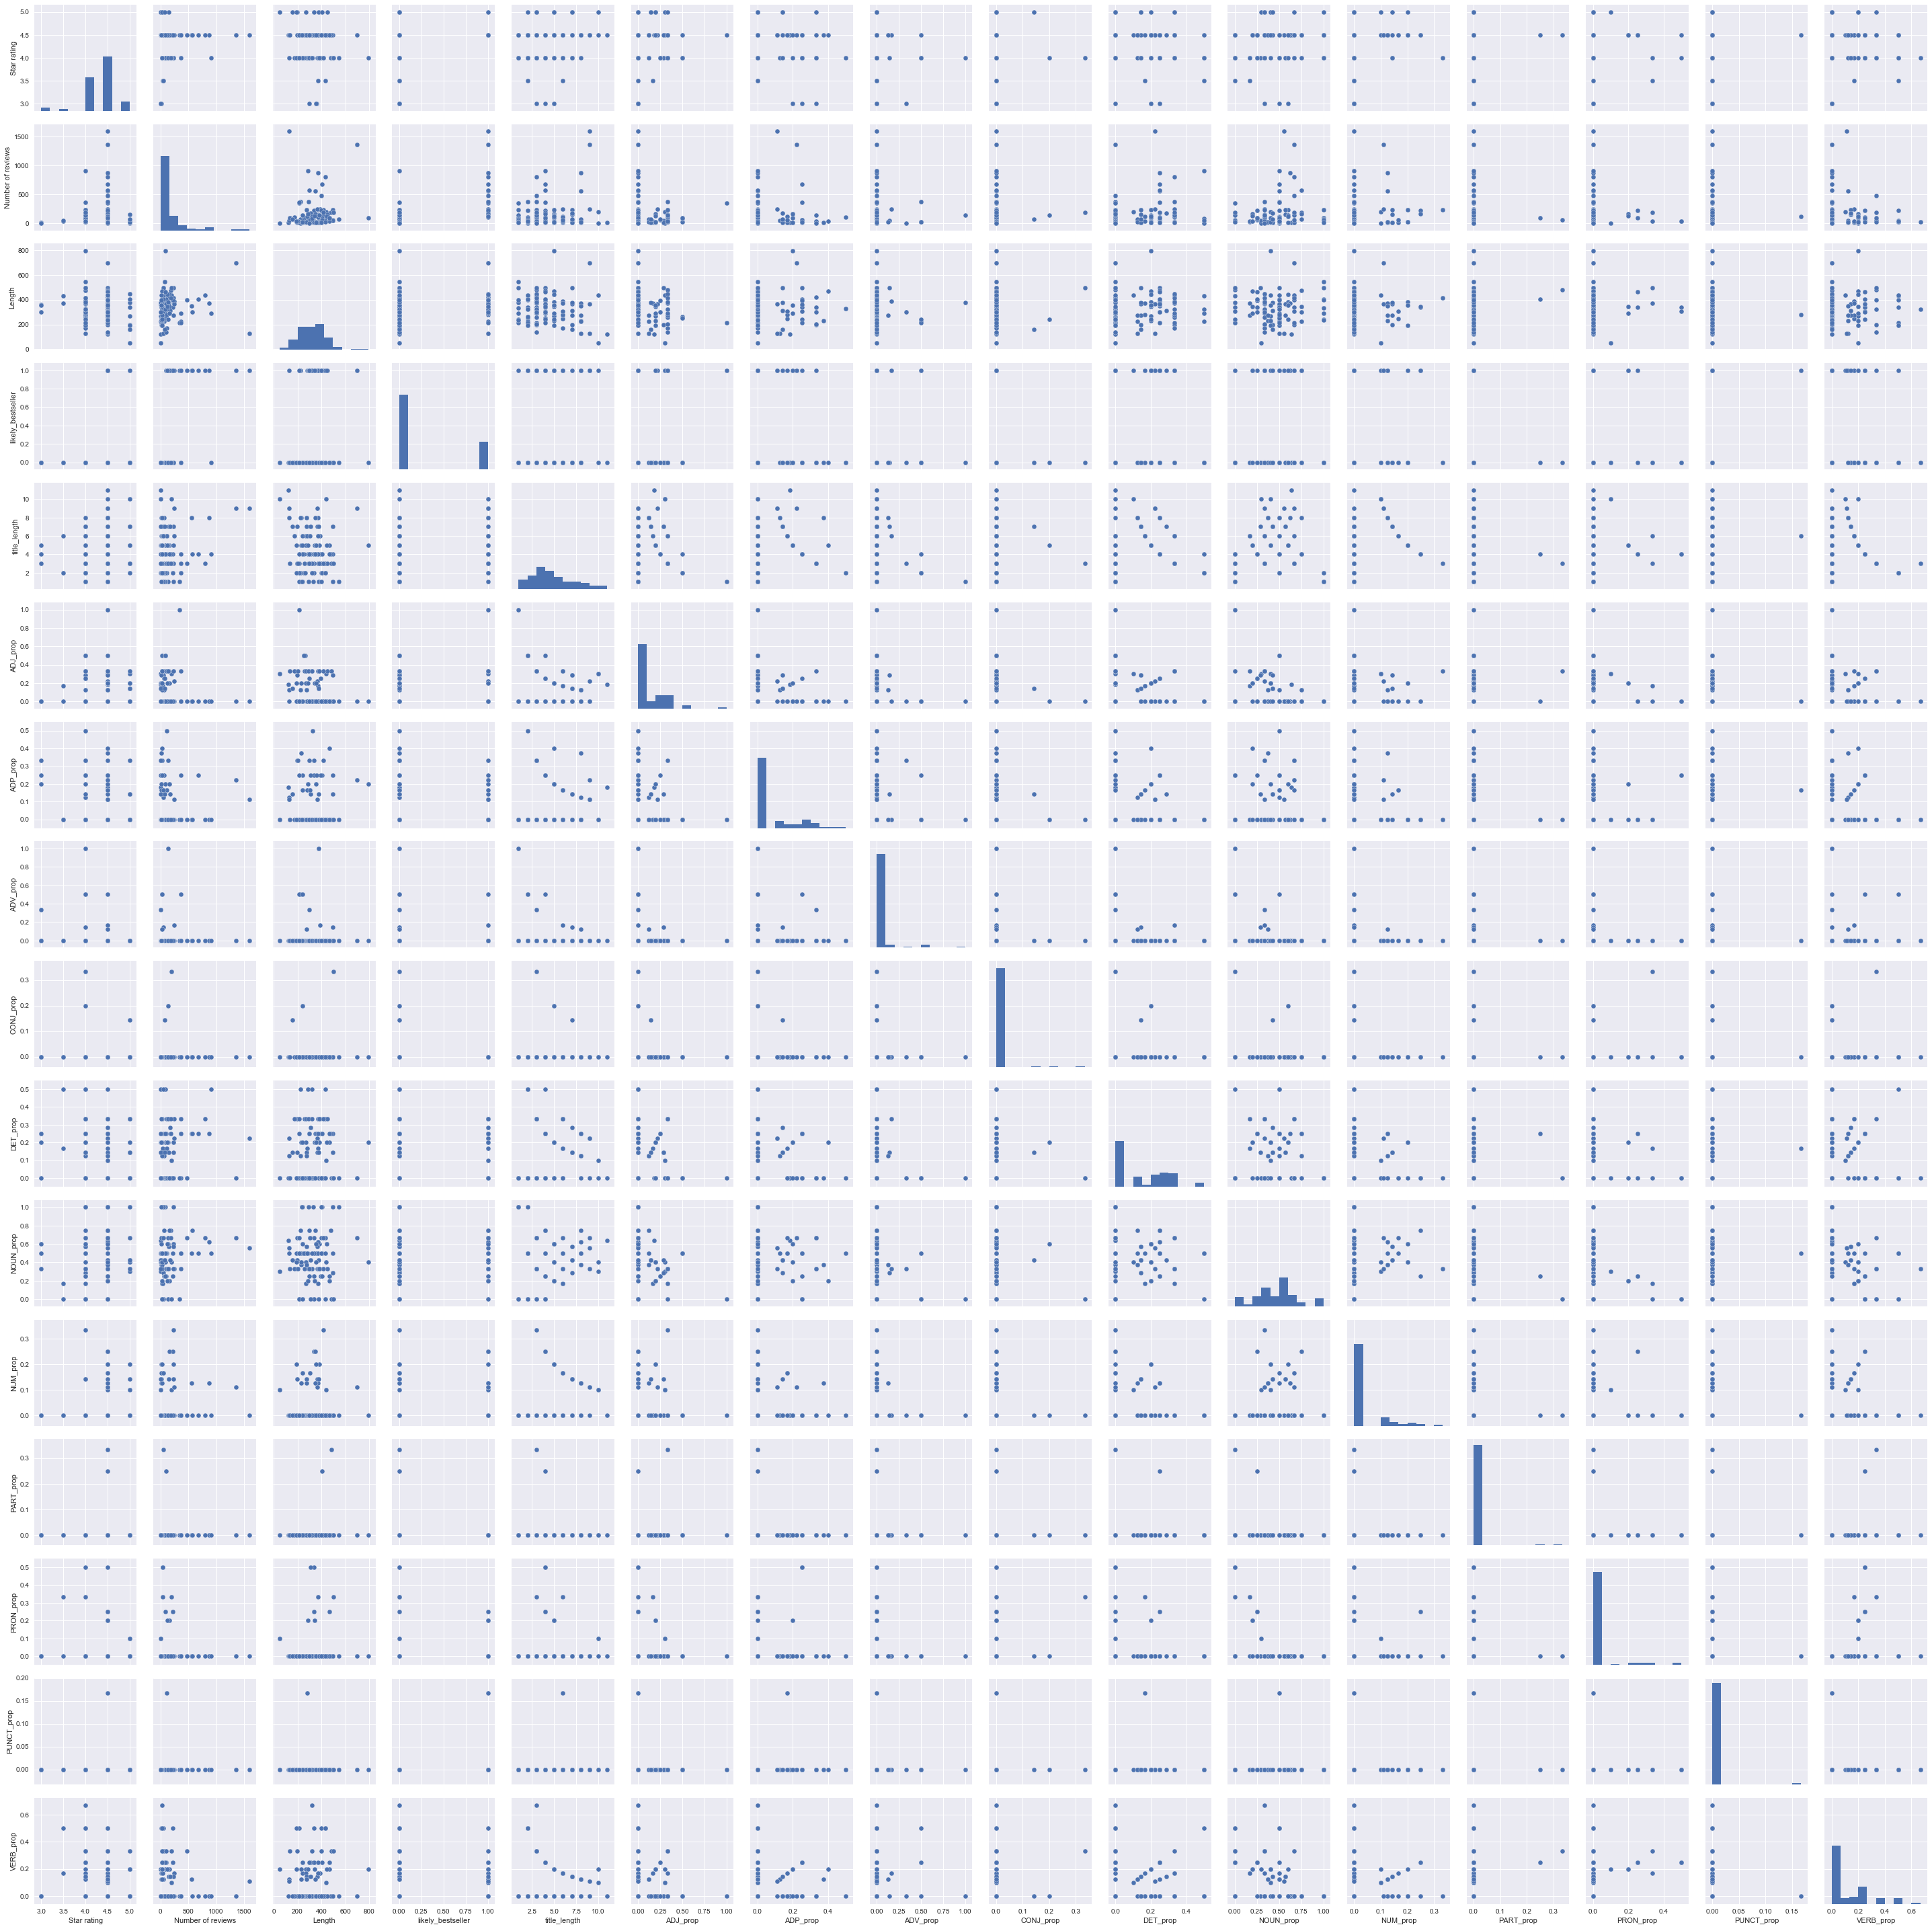

In [32]:
sns.pairplot(df)

In [83]:
df_bs = df[df['likely_bestseller'] == 1]
df_nbs = df[df['likely_bestseller'] == 0]

In [84]:
df_bs.shape

(27, 20)

In [85]:
df_nbs.shape

(73, 20)

In [36]:
df_bs.to_csv('bestsellers.csv', sep='\t')

In [37]:
df_nbs.to_csv('not_bestsellers.csv', sep='\t')

In [51]:
df.to_csv('all_titles.csv', sep='\t')

In [38]:
# 

In [39]:
# topics, subset bestsellers and not and see popular words, tool for detecting gender in names, dummies for top
# publishers, pairplot with publisher, # reviews, star rating

In [46]:
bs_titles_text = ' '.join(df_bs['title_clean'])

In [47]:
bs_titles_text

u'girl in pieces just juliet tell me three things the fever code book five saven deception scifi alien romance the saven series book 1 paper princess a novel the royals book 1 the sun is also a star salt to the sea broken prince a novel the royals book 2 the tales of beedle the bard hogwarts library book on the meldon plain the fourline trilogy book 2 star wars ahsoka calamity the reckoners adorkable empire of storms throne of glass series book 5 elementals 2 the blood of the hydra the thousandth floor elementals 3 the head of medusa if i was your girl the blue sword all american boys elite a hunter novel love gelato opposition a lux novel one paris summer blink the first time she drowned walk the edge thunder road'

In [49]:
nbs_titles_text = ' '.join(df_nbs['title_clean'])

In [50]:
nbs_titles_text

u'mistrust dork in love tales of my dorky love life teen romance warrior cats battle warrior cats werecat ya paranormal book 4 out of beat boys of fallout book 1 a different truth the passion of dolssa his to claim hunger is the best sauce mated to the alpha king king of beasts if i fix you if wishes were horses a bittersweet farm novella as old as time a twisted tale wake city of light book 1 suddenly the best possible answer a novel the crush dilemma dear aubrey book 1 infinity rises the infinity trilogy book 2 infinity reborn the infinity trilogy book 3 age of order cling a post apocalyptic thriller faerie rift the crown the selection the allstars because i love you purple moon the last time we were us firstlife an everlife novel my sister rosa capture the world the opposite of ordinary dragonbound immortal the dragonrider chronicles ellas twisted senior year nerd of the year three dark crowns alien frog prince a space age fairy tale begin again with malice passenger holding up the 

In [53]:
df.columns

Index([       u'Book title',       u'Author name',       u'Star rating',
       u'Number of reviews',            u'Length',         u'Publisher',
       u'likely_bestseller',       u'title_clean',      u'title_length',
                u'ADJ_prop',          u'ADP_prop',          u'ADV_prop',
               u'CONJ_prop',          u'DET_prop',         u'NOUN_prop',
                u'NUM_prop',         u'PART_prop',         u'PRON_prop',
              u'PUNCT_prop',         u'VERB_prop'],
      dtype='object')

In [55]:
df.columns = ['book_title', 'author_name', 'star_rating', 'num_reviews', 'length', 'publisher', 'likely_bestseller',
             'title_clean', 'title_length', 'ADJ_prop', 'ADP_prop', 'ADV_prop', 'CONJ_prop', 'DET_prop', 'NOUN_prop',
              'NUM_prop', 'PART_prop', 'PRON_prop', 'PUNCT_prop', 'VERB_prop']

In [ ]:
#### topic modeling ####

In [52]:
import patsy

In [57]:
y, X = patsy.dmatrices('likely_bestseller ~ C(publisher) + C(author_name) + length + title_length + ADJ_prop + ADP_prop + ADV_prop + CONJ_prop + DET_prop + NOUN_prop + NUM_prop + PART_prop + PRON_prop + PUNCT_prop + VERB_prop', data=df, return_type='dataframe')



In [69]:
X.shape

(100, 164)

In [58]:
from sklearn.preprocessing import StandardScaler

In [59]:
ss = StandardScaler()
Xs = ss.fit_transform(X)

In [60]:
from sklearn.model_selection import cross_val_score

In [61]:
from sklearn.naive_bayes import BernoulliNB

In [1]:
#bnb = BernoulliNB()
#scores = cross_val_score(bnb, X, y=y, cv=5)

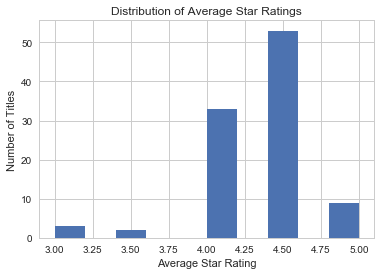

In [81]:
plt.hist(df['star_rating'])
plt.xlabel('Average Star Rating')
plt.ylabel('Number of Titles')
plt.title('Distribution of Average Star Ratings')


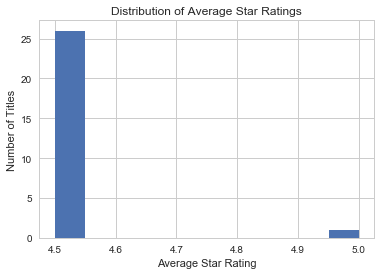

In [86]:
plt.hist(df_bs['star_rating'])
plt.xlabel('Average Star Rating')
plt.ylabel('Number of Titles')
plt.title('Distribution of Average Star Ratings')

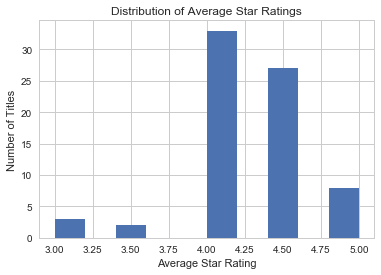

In [87]:
plt.hist(df_nbs['star_rating'])
plt.xlabel('Average Star Rating')
plt.ylabel('Number of Titles')
plt.title('Distribution of Average Star Ratings')

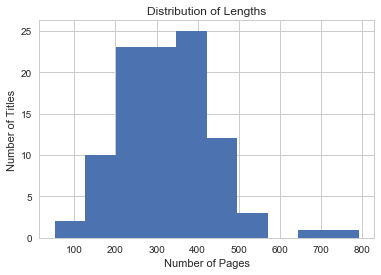

In [88]:
plt.hist(df['length'])
plt.xlabel('Number of Pages')
plt.ylabel('Number of Titles')
plt.title('Distribution of Lengths')

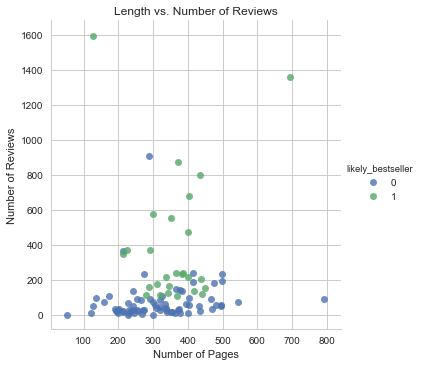

In [95]:
sns.lmplot('length', 'num_reviews', df, hue='likely_bestseller', fit_reg=False)
plt.xlabel('Number of Pages')
plt.ylabel('Number of Reviews')
plt.title('Length vs. Number of Reviews')

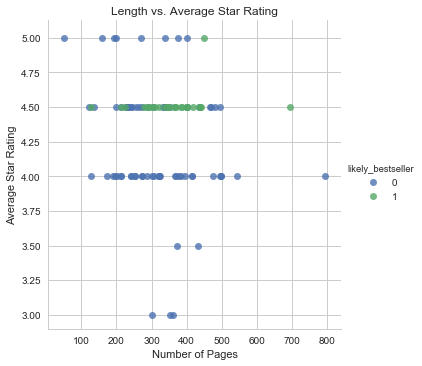

In [93]:
sns.lmplot('length', 'star_rating', df, hue='likely_bestseller', fit_reg=False)
plt.xlabel('Number of Pages')
plt.ylabel('Average Star Rating')
plt.title('Length vs. Average Star Rating')

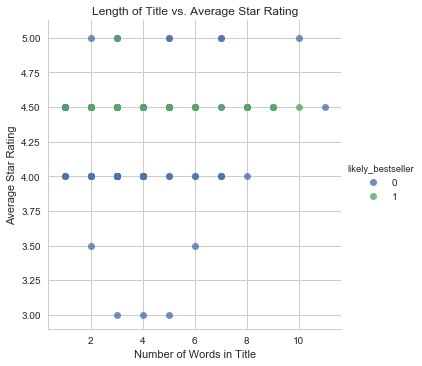

In [94]:
sns.lmplot('title_length', 'star_rating', df, hue='likely_bestseller', fit_reg=False)
plt.xlabel('Number of Words in Title')
plt.ylabel('Average Star Rating')
plt.title('Length of Title vs. Average Star Rating')

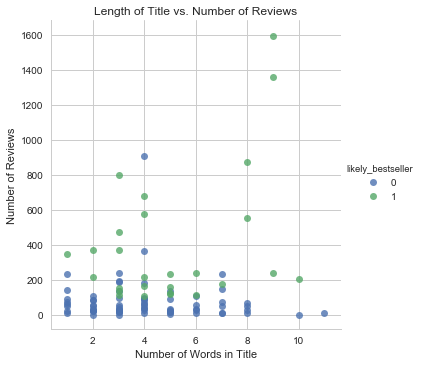

In [96]:
sns.lmplot('title_length', 'num_reviews', df, hue='likely_bestseller', fit_reg=False)
plt.xlabel('Number of Words in Title')
plt.ylabel('Number of Reviews')
plt.title('Length of Title vs. Number of Reviews')

ValueError: First argument must be a sequence

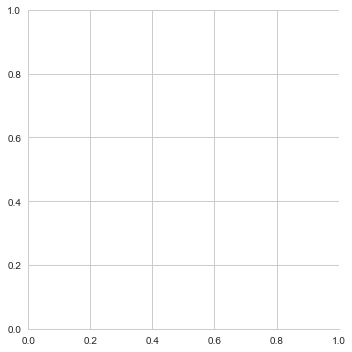

In [99]:
sns.lmplot('publisher', 'num_reviews', df, hue='likely_bestseller', fit_reg=False)
plt.xlabel('Publisher')
plt.ylabel('Number of Reviews')
plt.title('Publisher vs. Number of Reviews')

In [100]:
from nltk.tokenize import word_tokenize

In [102]:
df['author_tokens'] = [word_tokenize(x) for x in df['author_name']]

In [103]:
df.head()

,book_title,author_name,star_rating,num_reviews,length,publisher,likely_bestseller,title_clean,title_length,ADJ_prop,...,ADV_prop,CONJ_prop,DET_prop,NOUN_prop,NUM_prop,PART_prop,PRON_prop,PUNCT_prop,VERB_prop,author_tokens
0,Mistrust,Margaret McHeyzer,4.5,64,333,Amazon,0,mistrust,1,0.000000,...,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,"[Margaret, McHeyzer]"
1,Girl in Pieces,Kathleen Glasgow,4.5,139,418,Delacorte,1,girl in pieces,3,0.000000,...,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,"[Kathleen, Glasgow]"
2,Just Juliet,Charlotte Reagan,4.5,369,224,Inkitt,1,just juliet,2,0.000000,...,0.5,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,"[Charlotte, Reagan]"
3,Dork in Love ~ Tales of My Dorky Love Life: Te...,Ann Writes,4.5,9,122,Amazon,0,dork in love tales of my dorky love life teen ...,11,0.181818,...,0.0,0.0,0.0,0.636364,0.0,0.0,0.0,0.0,0.0,"[Ann, Writes]"
4,Warrior Cats: Battle (Warrior Cats (Werecat YA...,Tiyana Angel,5.0,1,52,Guardian Angel Press,0,warrior cats battle warrior cats werecat ya pa...,10,0.300000,...,0.0,0.0,0.0,0.300000,0.1,0.0,0.1,0.0,0.2,"[Tiyana, Angel]"


In [106]:
df['author_first'] = [x[0] for x in df['author_tokens']]
df['author_last'] = [x[-1] for x in df['author_tokens']]

df.head()

,book_title,author_name,star_rating,num_reviews,length,publisher,likely_bestseller,title_clean,title_length,ADJ_prop,...,DET_prop,NOUN_prop,NUM_prop,PART_prop,PRON_prop,PUNCT_prop,VERB_prop,author_tokens,author_first,author_last
0,Mistrust,Margaret McHeyzer,4.5,64,333,Amazon,0,mistrust,1,0.000000,...,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,"[Margaret, McHeyzer]",Margaret,McHeyzer
1,Girl in Pieces,Kathleen Glasgow,4.5,139,418,Delacorte,1,girl in pieces,3,0.000000,...,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,"[Kathleen, Glasgow]",Kathleen,Glasgow
2,Just Juliet,Charlotte Reagan,4.5,369,224,Inkitt,1,just juliet,2,0.000000,...,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,"[Charlotte, Reagan]",Charlotte,Reagan
3,Dork in Love ~ Tales of My Dorky Love Life: Te...,Ann Writes,4.5,9,122,Amazon,0,dork in love tales of my dorky love life teen ...,11,0.181818,...,0.0,0.636364,0.0,0.0,0.0,0.0,0.0,"[Ann, Writes]",Ann,Writes
4,Warrior Cats: Battle (Warrior Cats (Werecat YA...,Tiyana Angel,5.0,1,52,Guardian Angel Press,0,warrior cats battle warrior cats werecat ya pa...,10,0.300000,...,0.0,0.300000,0.1,0.0,0.1,0.0,0.2,"[Tiyana, Angel]",Tiyana,Angel


In [109]:
df['author_first_initial'] = [x[0] for x in df['author_first']]
df['author_last_initial'] = [x[0] for x in df['author_last']]

In [110]:
df.head()

,book_title,author_name,star_rating,num_reviews,length,publisher,likely_bestseller,title_clean,title_length,ADJ_prop,...,NUM_prop,PART_prop,PRON_prop,PUNCT_prop,VERB_prop,author_tokens,author_first,author_last,author_first_initial,author_last_initial
0,Mistrust,Margaret McHeyzer,4.5,64,333,Amazon,0,mistrust,1,0.000000,...,0.0,0.0,0.0,0.0,0.0,"[Margaret, McHeyzer]",Margaret,McHeyzer,M,M
1,Girl in Pieces,Kathleen Glasgow,4.5,139,418,Delacorte,1,girl in pieces,3,0.000000,...,0.0,0.0,0.0,0.0,0.0,"[Kathleen, Glasgow]",Kathleen,Glasgow,K,G
2,Just Juliet,Charlotte Reagan,4.5,369,224,Inkitt,1,just juliet,2,0.000000,...,0.0,0.0,0.0,0.0,0.0,"[Charlotte, Reagan]",Charlotte,Reagan,C,R
3,Dork in Love ~ Tales of My Dorky Love Life: Te...,Ann Writes,4.5,9,122,Amazon,0,dork in love tales of my dorky love life teen ...,11,0.181818,...,0.0,0.0,0.0,0.0,0.0,"[Ann, Writes]",Ann,Writes,A,W
4,Warrior Cats: Battle (Warrior Cats (Werecat YA...,Tiyana Angel,5.0,1,52,Guardian Angel Press,0,warrior cats battle warrior cats werecat ya pa...,10,0.300000,...,0.1,0.0,0.1,0.0,0.2,"[Tiyana, Angel]",Tiyana,Angel,T,A


In [111]:
df.to_csv('all_titles.csv', sep='\t')

In [ ]:
# Exporting the DataFrame to csv to explore more plotting in Tableau